### Produce scores for Arpit
---

* 2021 06 01
* 2021 07 01
* 2021 09 15 - prod and dev

In [1]:
import pandas as pd
import sys, os, json, s3fs
import matplotlib.pyplot as plt
from smart_open import open
import pickle as pkl
import seaborn as sns
import rdsutils.swap_set_analysis as ssa
from rdsutils.post_implementation_testing import plot_score_dist, get_psi, get_overlap_and_diff
from rdsutils.post_implementation_testing import plot_difference, get_combined_dfs, get_feature_comparison_report

plt.style.use("seaborn")

sys.path.append('../..')
import src.monitoring.utils as mu

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
prod_path = f"s3://sofi-data-science/jxu/data_dump/money_customer_risk/20210916-dev-prod-alignment/prod.parquet"
dev_path = "../../data/combined_all_features/combined_1632521410.feather"
s3_path = "s3://sofi-data-science/jxu/data_dump/money_customer_risk/"

prod_df = pd.read_parquet(prod_path)
dev_df = pd.read_feather(dev_path)

prev_june_df = pd.read_csv(os.path.join(s3_path, "202106-scores.csv"))
prev_july_df = pd.read_csv(os.path.join(s3_path, "202107-scores.csv"))

In [3]:
# load models

with open("../../config.json", "r") as f:
    config = json.load(f)
    mpaths = config["monitoring_config"]["model_paths"]
    
with open(mpaths["incumbent_model"], "rb") as f:
    incumbent_model = pkl.load(f)
    
with open(mpaths["customer_refitted_2021Q1"], "rb") as f:
    refitted_model = pkl.load(f)

In [4]:
def get_risk_groups(serie):
    return pd.cut(serie.round(), [300, 474, 510, 560, 600, 850], 
                  right=True, labels=[f'RG{i}' for i in range(1, 6)],
                  include_lowest=True)

def get_risk_groups_refitted(serie):
    return pd.cut(serie.round(), [300, 520, 550, 570, 590, 850], 
                  right=True, labels=[f'RG{i}' for i in range(1, 6)],
                  include_lowest=True)

### 2021 June July

In [5]:
df = dev_df[(dev_df.is_static)
            & (dev_df.sample_date.isin([pd.to_datetime("2021-06-01"),
                                        pd.to_datetime("2021-07-01")]))]

In [6]:
# other setups
features = incumbent_model.feature_name_

df = mu.prep_customer_data(df)  # get is_active here
print(df[["sample_date", "is_active"]].value_counts())

df["pred_incumbent"] = incumbent_model.predict_proba(df[features])[:,1]
df["pred_refitted"] = refitted_model.predict_proba(df[features])[:,1]

df["score_incumbent"] = mu.scale_scores(df["pred_incumbent"])
df["score_refitted"] = mu.scale_scores(df["pred_refitted"])

df["rg_incumbent"] = get_risk_groups(df["score_incumbent"])
df["rg_refitted"] = get_risk_groups_refitted(df["score_refitted"])

sample_date  is_active
2021-07-01   False        796556
2021-06-01   False        758401
2021-07-01   True         163438
2021-06-01   True         152015
dtype: int64


In [7]:
june_df = df[df.sample_date==pd.to_datetime("2021-06-01")]
july_df = df[df.sample_date==pd.to_datetime("2021-07-01")]

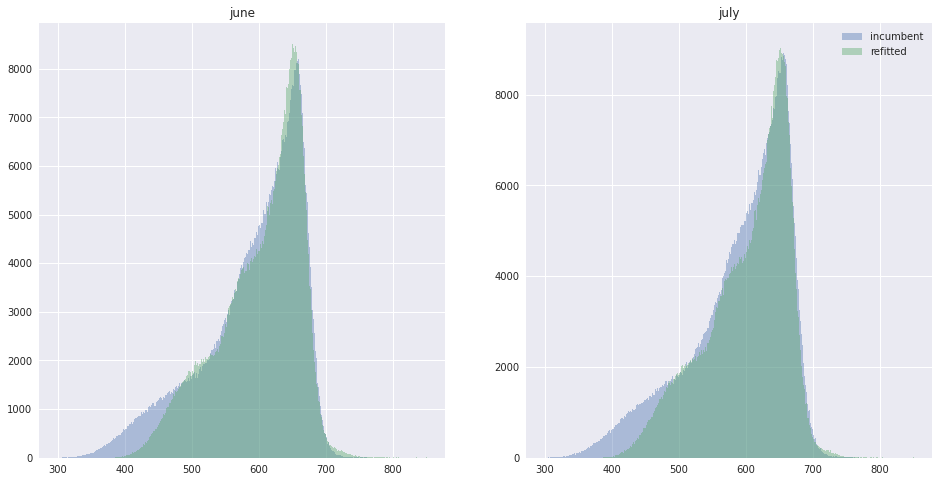

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
nbins = 500
june_df.score_incumbent.hist(bins=nbins, alpha=0.4, ax=axs[0], label="incumbent")
june_df.score_refitted.hist(bins=nbins, alpha=0.4, ax=axs[0], label="refitted")
axs[0].set_title("june")

july_df.score_incumbent.hist(bins=nbins, alpha=0.4, ax=axs[1], label="incumbent")
july_df.score_refitted.hist(bins=nbins, alpha=0.4, ax=axs[1], label="refitted")
axs[1].set_title("july")
plt.legend()

Text(0.5, 1.0, 'Risk Group Shift - july')

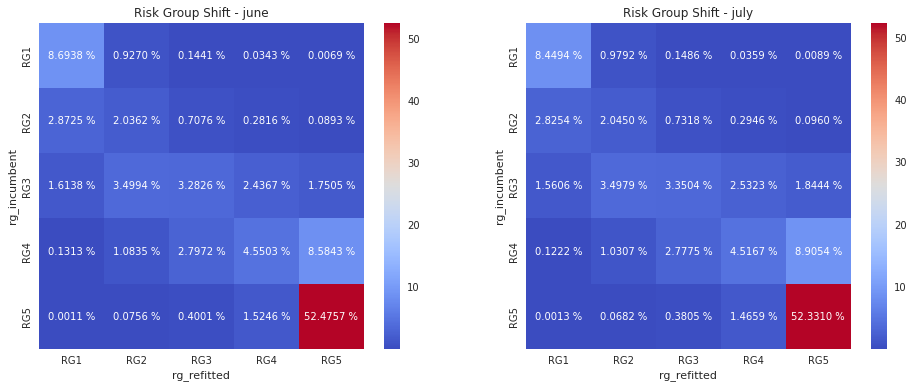

In [9]:
# rg shifts
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

rg_incumbent = "rg_incumbent"
rg_refit = "rg_refitted"

df_ = june_df
table = df_[[rg_incumbent, rg_refit]].value_counts(normalize=True).sort_index().reset_index()
table.columns = [rg_incumbent, rg_refit, 'counts']
table = pd.pivot_table(table, values='counts', index=rg_incumbent, 
                       columns=rg_refit, fill_value=0) * 100

hm = sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.4f', ax=axs[0])
for t in hm.texts: t.set_text(t.get_text() + " %")
axs[0].set_title(f'Risk Group Shift - june')

df_ = july_df
table = df_[[rg_incumbent, rg_refit]].value_counts(normalize=True).sort_index().reset_index()
table.columns = [rg_incumbent, rg_refit, 'counts']
table = pd.pivot_table(table, values='counts', index=rg_incumbent, 
                       columns=rg_refit, fill_value=0) * 100

hm = sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.4f', ax=axs[1])
for t in hm.texts: t.set_text(t.get_text() + " %")

axs[1].set_title(f'Risk Group Shift - july')

In [10]:
june_df.shape, prev_june_df.shape

((910416, 104), (908972, 10))

In [11]:
july_df.shape, prev_july_df.shape

((959994, 104), (958235, 10))

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn")


def plot_difference(expected_sequence, actual_sequence, 
                    figsize=(9,7), bins=10, title='', fig=None, ax=None):
    """ Plot the distr of difference of two sequences 
    Two sequences should have the same size
    """
    assert(len(expected_sequence) == len(actual_sequence))
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        
    seq = np.array(expected_sequence) - np.array(actual_sequence)
    ax.hist(seq, alpha=0.6, bins=bins, label='exp - actual')
    ax.set_title(title)
    ax.legend()
    return fig, ax

def plot_score_dist(dev_score, prod_score, figsize=(9,7), 
                    dev_label='development', prod_label='production',
                    bins=10, title='', fig=None, ax=None):
    """ Compare distributions of two scores
    @params dev_score: sequence of scores
    @params prod_score: sequence of scores
    @params figsize: tuple
    @returns fig: plt.figure object
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    ax.hist(dev_score, alpha=0.5, bins=bins, label=dev_label)
    ax.hist(prod_score, alpha=0.5, bins=bins, label=prod_label)
    ax.set_title(title)
    ax.legend()
    return fig, ax

In [13]:
combined_june_df = get_combined_dfs(june_df, prev_june_df, index_col="business_account_number")

(<Figure size 864x360 with 2 Axes>,
 <AxesSubplot:title={'center':'score_refitted: differences'}>)

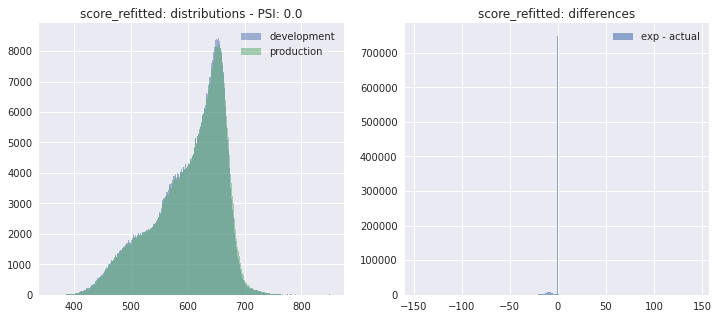

In [14]:
ft = "score_refitted"
ft_dev = ft + "_exp"  # updated
ft_prod = ft + "_act"  # prev

psi = get_psi(combined_june_df[ft_dev].rename().to_frame(), 
                         combined_june_df[ft_prod].rename().to_frame()).loc[0, "psi"]
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
plot_score_dist(combined_june_df[ft_dev], combined_june_df[ft_prod], bins=nbins, fig=fig, ax=axs[0], title=f"{ft}: distributions - PSI: {round(psi, 2)}")
plot_difference(combined_june_df[ft_dev], combined_june_df[ft_prod], bins=nbins, fig=fig, ax=axs[1], title=f"{ft}: differences") 

In [15]:
combined_july_df = get_combined_dfs(july_df, prev_july_df, index_col="business_account_number")

(<Figure size 864x360 with 2 Axes>,
 <AxesSubplot:title={'center':'score_refitted: differences'}>)

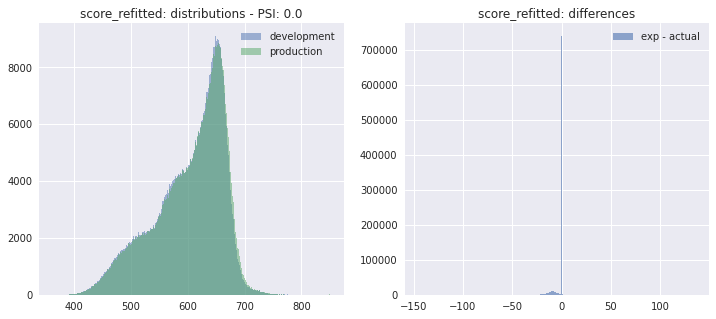

In [16]:
ft = "score_refitted"
ft_dev = ft + "_exp"  # updated
ft_prod = ft + "_act"  # prev

psi = get_psi(combined_july_df[ft_dev].rename().to_frame(), 
                         combined_july_df[ft_prod].rename().to_frame()).loc[0, "psi"]
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
plot_score_dist(combined_july_df[ft_dev], combined_july_df[ft_prod], bins=nbins, fig=fig, ax=axs[0], title=f"{ft}: distributions - PSI: {round(psi, 2)}")
plot_difference(combined_july_df[ft_dev], combined_july_df[ft_prod], bins=nbins, fig=fig, ax=axs[1], title=f"{ft}: differences") 

In [17]:
cols = ["business_account_number", "borrower_id", "sample_date", 
        "pred_incumbent", "pred_refitted", "score_incumbent", "score_refitted",
        "rg_incumbent", "rg_refitted"]
june_df[cols].to_csv(os.path.join(s3_path, "20210925-update-fix-fraud-score-2", "202106-scores-updated.csv"))
july_df[cols].to_csv(os.path.join(s3_path, "20210925-update-fix-fraud-score-2", "202107-scores-updated.csv"))

prev_june_df[cols].to_csv(os.path.join(s3_path, "20210925-update-fix-fraud-score-2", "202106-scores-prev.csv"))
prev_july_df[cols].to_csv(os.path.join(s3_path, "20210925-update-fix-fraud-score-2", "202107-scores-prev.csv"))

### 2021-09-15 Dev and Prod

In [18]:
prod_df = pd.read_parquet(prod_path)
dev_df = pd.read_feather(dev_path)

In [19]:
sample_date = "2021-09-15"
dev_df = dev_df[(dev_df.is_static) & (dev_df.sample_date==pd.Timestamp(sample_date))]

prod_df["last_checked_date"] = pd.to_datetime(prod_df["last_checked_date"])
prod_df["sample_date"] = prod_df["last_checked_date"].dt.date
prod_df = prod_df[prod_df["sample_date"]==pd.Timestamp(sample_date)]

In [20]:
dev_df = mu.preprocess(dev_df)

In [21]:
dev_df = mu.prep_customer_data(dev_df)  # get is_active here
features = incumbent_model.feature_name_

dev_df["pred_incumbent"] = incumbent_model.predict_proba(dev_df[features])[:,1]
dev_df["score_incumbent"] = mu.scale_scores(dev_df["pred_incumbent"])

prod_df["pred_incumbent"] = incumbent_model.predict_proba(prod_df[features])[:,1]
prod_df["score_incumbent"] = mu.scale_scores(prod_df["pred_incumbent"])

dev_df["pred_refitted"] = incumbent_model.predict_proba(dev_df[features])[:,1]
dev_df["score_refitted"] = mu.scale_scores(dev_df["pred_refitted"])

prod_df["pred_refitted"] = incumbent_model.predict_proba(prod_df[features])[:,1]
prod_df["score_refitted"] = mu.scale_scores(prod_df["pred_refitted"])

In [22]:
dev_df["party_id"] = dev_df["user_id"]
prod_df["user_id"] = prod_df["party_id"]

In [41]:
columns = ["party_id", "sample_date", "pred_incumbent", "score_incumbent",
           "pred_refitted", "score_refitted"]

dev_df[columns+["business_account_number"]].to_csv(os.path.join(s3_path, "20210925-update-fix-fraud-score-2", "20210915_dev_scores_updated.csv"))
prod_df[columns].to_csv(os.path.join(s3_path, "20210925-update-fix-fraud-score-2", "20210915_prod_scores_updated.csv"))

### some analysis

In [29]:
combined_df = get_combined_dfs(dev_df, prod_df, index_col="user_id")

(<Figure size 864x360 with 2 Axes>,
 <AxesSubplot:title={'center':'score_incumbent: differences'}>)

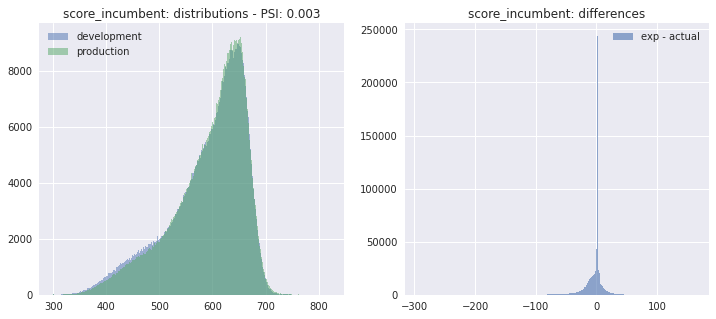

In [35]:
ft = "score_incumbent"
ft_dev = ft + "_exp"
ft_prod = ft + "_act"

psi = get_psi(combined_df[ft_dev].rename().to_frame(), 
                         combined_df[ft_prod].rename().to_frame()).loc[0, "psi"]
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
plot_score_dist(combined_df[ft_dev], combined_df[ft_prod], bins=nbins, fig=fig, ax=axs[0], title=f"{ft}: distributions - PSI: {round(psi, 3)}")
plot_difference(combined_df[ft_dev], combined_df[ft_prod], bins=nbins, fig=fig, ax=axs[1], title=f"{ft}: differences") 

(<Figure size 864x360 with 2 Axes>,
 <AxesSubplot:title={'center':'score_refitted: differences'}>)

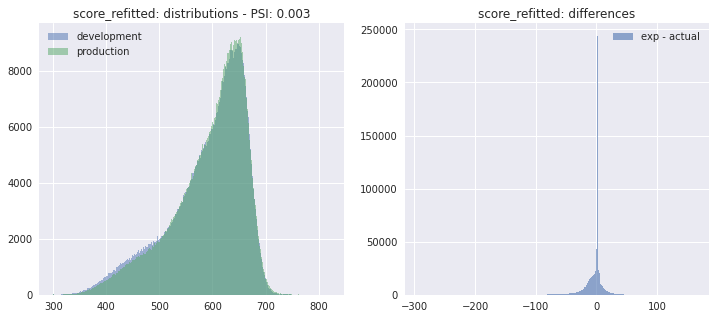

In [36]:
ft = "score_refitted"
ft_dev = ft + "_exp"
ft_prod = ft + "_act"

psi = get_psi(combined_df[ft_dev].rename().to_frame(), 
                         combined_df[ft_prod].rename().to_frame()).loc[0, "psi"]
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
plot_score_dist(combined_df[ft_dev], combined_df[ft_prod], bins=nbins, fig=fig, ax=axs[0], title=f"{ft}: distributions - PSI: {round(psi, 3)}")
plot_difference(combined_df[ft_dev], combined_df[ft_prod], bins=nbins, fig=fig, ax=axs[1], title=f"{ft}: differences") 

In [34]:
get_psi(dev_df[features], prod_df[features]).round(2).head()

,feature,psi
15,nr_past_transactions,0.56
6,transaction_as_pct_of_balance,0.11
38,transaction_code_encoded,0.06
26,time_since_last_transaction,0.03
18,address_risk_score,0.02


In [52]:
((combined_df["score_incumbent_exp"] == combined_df["score_incumbent_act"])
| (combined_df["score_incumbent_exp"].isna() & combined_df["score_incumbent_act"].isna())
| ((combined_df["score_incumbent_exp"]-combined_df["score_incumbent_act"]).abs()<=20)).value_counts()

True     963285
False    146640
dtype: int64

In [53]:
df__ = combined_df[combined_df.is_active_exp]
((df__["score_incumbent_exp"] == df__["score_incumbent_act"])
| (df__["score_incumbent_exp"].isna() & df__["score_incumbent_act"].isna())
| ((df__["score_incumbent_exp"]-df__["score_incumbent_act"]).abs()<=20)).value_counts()

True     110839
False     51152
dtype: int64